~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Electronic Health Record (EHR) Navigator Agent

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/master/notebooks/ehr_navigator_agent.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedgemma%2Fmaster%2Fnotebooks%2Fehr_navigator_agent.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/master/notebooks/ehr_navigator_agent.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

The sheer volume and complexity EHR data, often stored in the Fast Healthcare Interoperability Resources (FHIR) format, make AI agents a crucial tool for navigation and utilization. A complete patient record history often exceeds the context window of a standard Large Language Model (LLM), but an agent can intelligently fetch and act on the most relevant subsets of such large and complex record to answer specific questions and perform useful tasks.

### Objectives

This notebook demonstrates an agent developed using [LangGraph](https://www.langchain.com/langgraph) that leverages [MedGemma](https://developers.google.com/health-ai-developer-foundations/medgemma)'s comprehension of the FHIR standard to intelligently navigate a patient's health records. The agent operates through a structured, four-step process where it first:

1. **Identifies** available information,

2. **Plans** the retrieval of relevant details,

3. **Fetches** data iteratively, extracting key information, and

4. **Processes** the findings to deliver a complete answer.

### Costs
This tutorial uses billable components of Google Cloud Platform (GCP):

- [Vertex AI - Online Prediction Endpoints](https://docs.cloud.google.com/vertex-ai/docs/predictions/get-online-predictions)
- [Cloud Healthcare API - FHIR Store](https://docs.cloud.google.com/healthcare-api/docs/how-tos/fhir)

Learn about [Vertex AI online prediction pricing](https://cloud.google.com/vertex-ai/pricing?e=48754805#prediction-and-explanation), [Cloud Healthcare AI pricing](https://cloud.google.com/healthcare-api/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator?e=48754805) to generate a cost estimate based on your projected usage.

NOTE: For your convenience, the notebook initially uses a Cloud FHIR Store hosted by the [goo.gle/hai-def](http://goo.gle/hai-def) program. You will only be charged for data storage if you change the default configuration.

## Before you begin
You need the following to run this notebook:

1. A **MedGemma** Vertex AI online prediction endpoint. If you don't have access to an endpoint instance, deploy it via [Model Garden](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma). This notebook was tested using `medgemma-27b-text-it`.

3. A **Google Identity**. This identity can be a Gmail address (e.g., user@gmail.com), a non-Gmail personal email (e.g., user@foo.com), or a corporate/organizational email managed by your employer or school through Google Workspace or Google Cloud Identity (e.g., name@yourcompany.com). For details on managing or creating your Google account, visit https://account.google.com.

2. A **Google Cloud FHIR Store** containing patient data. In this notebook we use a public FHIR Store containing synthetic patinet data readable by anyone with a Google identity. If you'd like to test the notebook with your own data, refer to [how to create a FHIR Store](https://docs.cloud.google.com/healthcare-api/docs/how-tos/fhir). This notebook was tested with *HL7 FHIR R4* version.

4. A **Patient ID** from your FHIR Store to inquire about. You can list the syntehic patinet Ids in our public FHIR Store by running:

    ```http
    GET https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/fhirStores/synthetic-patients/fhir/Patient
    ```

## Test dataset

Testing was conducted using a synthetic dataset of 100 patients, generated via [Synthea Synthetic](https://github.com/synthetichealth/synthea). Therefore, these results may not fully represent real-world clinical scenarios.

## Known limitations
This notebook is intended solely to demonstrate concept feasibility and should not be viewed as a finished or approved product. It serves as a simplified example to illustrate capabilities; robust, production-ready applications would require significant additional features.

### Deployment
This implementation is not suitable for a production environment, which typically necessitates deployment via containerization, such as [LangServe](https://pypi.org/project/langserve/), or utilizing a managed service for building an agent, like [Vertex AI Agent Builder](https://cloud.google.com/blog/products/ai-machine-learning/more-ways-to-build-and-scale-ai-agents-with-vertex-ai-agent-builder?e=48754805).

### Feature Limitations
Since this is for demonstration purposes only, the current implementation has certain limitations and does not fully master the FHIR standard. The following key features, in particular, are not yet supported:

* **Date Awareness**: The ability to recognize the current date and filter records by date.

* **Reference Lookup**: The ability to look up FHIR references (e.g., following a link from a condition to a patient).

* **Data Requesting**: The ability to autonomously request more data from the source.

---
> **DISCLAIMER:** This demonstration is for illustrative purposes only and does not represent a finished or approved product. It is not representative of compliance to any regulations or standards for quality, safety or efficacy. Any real-world application would require additional development, training, and adaptation. The experience highlighted in this demo shows MedGemma's baseline capability for the displayed task and is intended to help developers and users explore possible applications and inspire further development.
---

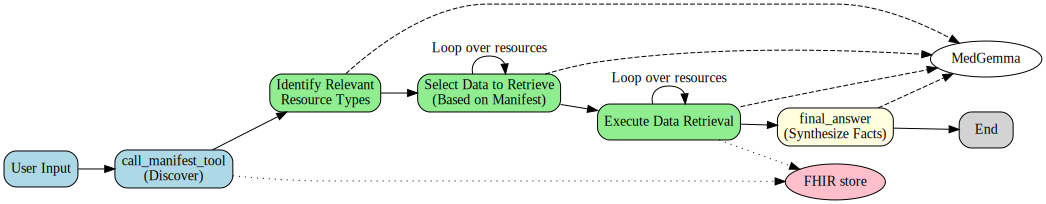

In [ ]:
# @title Agentic Workflow
# @markdown The agent's workflow is as follows:

# @markdown 1. **Discover**: Uses the `get_patient_data_manifest` tool to identify all available FHIR resource types and associated codes for the specified patient. This provides an overview of the data landscape.
# @markdown 2. **Identify Relevant Resource Types**: Based on the manifest and the user's question, the LLM (MedGemma) identifies the FHIR resource types most likely to contain the necessary information.
# @markdown 3. **Select Data to Retrieve**: Based on the relevant resource types and the manifest, the LLM (MedGemma) plans the specific `get_patient_fhir_resource` tool calls needed. This planning happens once at the beginning for the selected resource types.
# @markdown 4. **Execute & Collect Facts Sequentially**:
# @markdown     * Executes each planned tool call to retrieve a FHIR resource.
# @markdown     * Prompts the LLM (MedGemma) to act as a "fact filter agent", extracting **relevant facts** based *only* on the result of that specific call and the original user question for context. The reason for this apporach is that FHIR resources across an entire patient record may not fit in the LLM context window.
# @markdown     * All these individually collected sets of facts are gathered into a list.
# @markdown 5. **Final Answer**: After all planned tool calls are executed and relevant facts are collected from each, the agent generates the final, comprehensive answer by synthesizing information from the **complete list of collected facts**.

!apt -qqq install graphviz
import graphviz

graphviz_diagram = """digraph G {
  rankdir=LR; // Left to Right
  node [shape=box, style="rounded,filled"];

  // Define nodes
  start [label="User Input", fillcolor="lightblue"];
  manifest_tool [label="call_manifest_tool\n(Discover)", fillcolor="lightblue"];
  identify_relevant [label="Identify Relevant\nResource Types", fillcolor="lightgreen"];
  plan [label="Select Data to Retrieve\n(Based on Manifest)", fillcolor="lightgreen"];
  execute_tool [label="Execute Data Retrieval", fillcolor="lightgreen"];
  final_answer_node [label="final_answer\n(Synthesize Facts)", fillcolor="lightyellow"];
  end [label="End", fillcolor="lightgrey"];

  llm [label="MedGemma", shape=oval, fillcolor="white"];
  fhir [label="FHIR store", shape=oval, fillcolor="pink"];

  // Define main flow edges
  start -> manifest_tool;
  manifest_tool -> identify_relevant;
  identify_relevant -> plan;
  plan -> execute_tool;

  // Add a loop for the execute node
  plan -> plan [label="Loop over resources"];
  execute_tool -> execute_tool [label="Loop over resources"];

  execute_tool -> final_answer_node;
  final_answer_node -> end;

  // Add dotted edges to represent LLM interactions
  manifest_tool -> fhir [style=dotted];
  identify_relevant -> llm [style=dashed]; // LLM identifies relevant resource types
  plan -> llm [style=dashed]; // LLM selects data to retrieve
  execute_tool -> fhir [style=dotted];
  execute_tool -> llm [style=dashed]; // LLM summarizes facts
  final_answer_node -> llm [style=dashed]; // LLM synthesizes final answer
}"""

dot = graphviz.Source(graphviz_diagram)
display(dot)

In [ ]:
#@title Step 1 - Install dependencies

%pip install --upgrade --quiet langchain-google-vertexai langchain langchain-core google-api-python-client requests google-cloud-aiplatform langgraph "requests>=2.32.5,<3.0.0" "pyarrow>=14.0.0,<20.0.0a0"

In [ ]:
#@title Step 2 - Import dependecies and authenticate
import os
import json
import requests
from typing import Optional, TypedDict, Annotated, List, Union
import operator

# LangChain & LangGraph Imports
from langchain_google_vertexai import VertexAIModelGarden
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import render_text_description # Corrected import path
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# Google Auth Imports
from google.colab import auth
from google.auth import default as get_auth_default
from google.auth.transport import requests as google_auth_requests

print("Authenticating user...")
auth.authenticate_user()
print("Authentication successful.")

Authenticating user...
Authentication successful.


In [ ]:
#@title Step 3 - Set the parameters {run: "auto"}

YOUR_PROJECT_ID = 'hai-cd3-foundations'  #@param {type:"string"}
YOUR_REGION = 'us-central1'  #@param {type:"string"}
YOUR_ENDPOINT_ID = '1030'  #@param {type:"string"}
FHIR_STORE_URL = 'https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/fhirStores/synthetic-patients/fhir' #@param {type:"string"}
patient_id = "e4350e97-bb8c-70b7-9997-9e098cfacef8" #@param {type: "string"}
user_question = "What specific medications were administered to the patient during their sepsis encounter?" #@param {type: "string"}

os.environ["GOOGLE_CLOUD_PROJECT"] = YOUR_PROJECT_ID


In [ ]:
#@title Step 4 - Initialize MedGemma (the LLM)

try:
    llm = VertexAIModelGarden(
        project=YOUR_PROJECT_ID,
        location=YOUR_REGION,
        endpoint_id=YOUR_ENDPOINT_ID,
        allowed_model_args=["temperature", "max_tokens"]
    )
    print("✅ LLM Initialization successful.")
except Exception as e:
    print(f"❌ LLM Initialization FAILED: {e}")

In [ ]:
#@title Step 5 - Define FHIR Store as a tool

from urllib.parse import quote

# List of common resources. Patient was intentionally not included.
# This could be done using Patient/<id>/$everything
fhir_resource_types = [
    # Core Patient Information
    "Encounter",
    "Practitioner",

    # Clinical Findings & History
    "Condition",
    "Observation",
    "AllergyIntolerance",
    "FamilyMemberHistory",

    # Medications
    "MedicationRequest",
    "MedicationStatement",
    "MedicationAdministration",

    # Diagnostics & Procedures
    "DiagnosticReport",
    "Procedure",
    "ServiceRequest"
]

def _get_fhir_resource(resource_path: str) -> dict:
    """Helper function to make an authenticated GET request to the FHIR store and compact."""
    try:
        credentials, _ = get_auth_default()
        request = google_auth_requests.Request()
        credentials.refresh(request)
        headers = {"Authorization": f"Bearer {credentials.token}"}

        all_entries = []
        next_url = f"{FHIR_STORE_URL}/{resource_path}"

        while next_url:
            print(f"...[Tool] Making request to: {next_url[next_url.find('/fhir/'):]}")
            response = requests.get(next_url, headers=headers)
            response.raise_for_status()
            current_page = response.json()

            if "entry" in current_page:
                all_entries.extend(current_page["entry"])

            next_url = None # Reset next_url for each iteration
            for link in current_page.get("link", []):
                if link.get("relation") == "next":
                    next_url = link.get("url")
                    break

        # Reconstruct the bundle with all entries
        full_bundle = {"resourceType": "Bundle", "type": "searchset", "total": len(all_entries), "entry": all_entries}

        def clean(obj):
            # Remove .resource.meta (timestamps/versions) from all objects
            if isinstance(obj, list): return [clean(i) for i in obj]
            if isinstance(obj, dict): return {k: clean(v) for k, v in obj.items() if k != "meta"}
            return obj.split("/fhir/")[-1] if isinstance(obj, str) and "/fhir/" in obj else obj

        # [OPTIONAL] Strip technical metadata and shorten URLs
        for e in all_entries:
            e.pop("fullUrl", None);
            e.pop("search", None)
            if "resource" in e: e["resource"] = clean(e["resource"])

        return full_bundle
    except Exception as e:
        return {"error": f"An error occurred: {str(e)}"}

@tool
def get_patient_fhir_resource(patient_id: str, fhir_resource: str, filter_code: Optional[str] = None) -> str:
    """Gets a list of FHIR resources for a single patient.
    patient_id: The ID of the patient.
    fhir_resource: The FHIR resource type to retrieve (Observation, Condition, MedicationRequest, etc.)
    filter_code: A comma seperated list of code filter to apply to the resource (34117-2, 171207006, 82667-7, 8867-4, etc)
    """
    resource_path = f"{fhir_resource}?patient=Patient/{patient_id}"
    if filter_code:
        resource_path += f"&code={quote(filter_code.replace(" ",""))}"
    if "Medication" in fhir_resource:
        resource_path += f"&_include={fhir_resource}:medication"

    content = _get_fhir_resource(resource_path)

    # If the initial call with code:text returns no results, try with category:text
    if content.get("total", 0) == 0 and filter_code:
        print(f"...[Tool] No results found with 'code:text'. Retrying with 'category:text'...")
        resource_path = f"{fhir_resource}?patient=Patient/{patient_id}&category={quote(filter_code)}"
        content = _get_fhir_resource(resource_path)

    return json.dumps(content)

@tool
def get_patient_data_manifest(patient_id: str) -> str:
    """
    Gets a manifest of all available FHIR resources and their codes for a patient by
    querying the patient's entire record. Use this tool first to discover what data is available.
    """
    manifest = {}

    for resource_type in fhir_resource_types:
        resource_path = f"{resource_type}?patient=Patient/{patient_id}"
        print(f"...[Tool] Discovering all available {resource_type} resources for patient: {patient_id}")
        resources_json = _get_fhir_resource(resource_path)

        if isinstance(resources_json, dict) and resources_json.get("total", 0) > 0:
            # Process the bundle of resources returned by the $everything operation.
            for entry in resources_json.get("entry", []):
                resource = entry.get("resource", { })
                # Safely initialize the list for a new resource type.
                if resource_type not in manifest:
                    manifest[resource_type] = []

                # Extract the code text if it exists.
                if "code" in resource and "coding" in resource["code"]:
                  for code in resource.get("code").get("coding", []):
                    manifest[resource_type].append(f'{code.get("display", "")}={code.get("code", "")}')

    return manifest

# --- Tool Nodes for the Graph ---
manifest_tool_node = ToolNode([get_patient_data_manifest])
data_retrieval_tool_node = ToolNode([get_patient_fhir_resource])

print("✅ FHIR tools and nodes defined successfully.")

In [ ]:
#@title Step 6 - Create the EHR agent

import os
import json
import requests
from typing import Optional, TypedDict, Annotated, List, Union
import operator

# LangChain & LangGraph Imports
from langchain_google_vertexai import VertexAIModelGarden
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, ToolCall
from langchain_core.tools import render_text_description
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# Google Auth Imports
from google.colab import auth
from google.auth import default as get_auth_default
from google.auth.transport import requests as google_auth_requests

print("Authenticating user...")
auth.authenticate_user()
print("Authentication successful.")

import re
from IPython.display import Markdown, display

def exclude_thinking_component(text: str) -> str:
  """
  Removes the thinking block (delimited by <unused94> and <unused95>) from a string.
  """
  return re.sub(r"<unused94>.*?<unused95>", "", text, flags=re.DOTALL).strip()


def strip_json_decoration(text: str) -> str:
    """Removes JSON markdown fences from the start and end of a string."""
    cleaned = text.strip()
    return (
        cleaned[7:-3].strip() if cleaned.startswith('```json') and cleaned.endswith('```') else
        cleaned[3:-3].strip() if cleaned.startswith('```') and cleaned.endswith('```') else
        cleaned
    )

# 1. Define the State
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    patient_fhir_manifest: dict
    tool_output_summary: Annotated[list, operator.add]
    tool_calls_to_execute: list # Added to store the list of tool calls to make
    relevant_resource_types: list # New field to store relevant resource types

# 2. Define the Nodes and Edges
def call_manifest_tool_node(state):
    """The first step: uses the LLM to find the patient_id from the initial question and calls the get_patient_data_manifest tool."""
    last_message = state['messages'][-1]

    # Use the LLM to extract the patient_id
    extraction_prompt = (
        f"USER QUESTION: {last_message.content}\n\n"
        "You are an API request generator. Your task is to identify the patient ID "
        "from the user's question and output a JSON object to call the `get_patient_data_manifest` tool.\n\n"
        # Assumes 'get_patient_data_manifest' tool is in the global scope from the previous cell
        f"Your available tool is:\n{render_text_description([get_patient_data_manifest])}\n\n"
        "Generate the correct JSON to call the tool. Respond with only a single, raw JSON object.\n\n"
        "EXAMPLE:\n"
        "{\n"
        '  "name": "get_patient_data_manifest",\n'
        '  "args": {\n'
        '    "patient_id": "some-patient-id-from-the-question"\n'
        "  }\n"
        "}\n"
    )

    # Assumes 'llm' is in the global scope from the previous cell
    response_str = llm.invoke(extraction_prompt, max_tokens=1000, temperature=0.1)

    try:
        # Clean up potential markdown fences
        cleaned_response = response_str.strip().replace('```json', '').replace('```', '').strip()
        tool_call_json = json.loads(cleaned_response)

        # Create the tool call message
        tool_call_msg = AIMessage(
            content="",
            tool_calls=[{**tool_call_json, 'id': 'manifest_call'}]
        )

        # Assumes 'manifest_tool_node' is in the global scope from the previous cell
        tool_output_message = manifest_tool_node.invoke([tool_call_msg])[0]

        # Parse the JSON string content into a dictionary
        manifest_dict = json.loads(tool_output_message.content)

        return {"patient_fhir_manifest": manifest_dict} # Extract content from ToolMessage

    except Exception as e:
        print(f"Error calling manifest tool: {e}")
        # Return an empty dictionary for the manifest in case of error
        return {"patient_fhir_manifest": {}}

def identify_relevant_resource_types(state):
    """Uses the manifest and user question to identify relevant FHIR resource types."""
    display(Markdown("# Identifying Relevant Resource Types"))
    manifest = state.get('patient_fhir_manifest', {})
    user_question = state['messages'][1].content

    # Format manifest content as markdown
    manifest_content = ""
    for resource_type, codes in manifest.items():
        manifest_content += f"**{resource_type}**: "
        if codes:
            manifest_content += f"Available codes include: {', '.join(codes)}\n"
        else:
            manifest_content += "Present (no specific codes found)\n"

    display(Markdown(f"### Patient Data Manifest\n\n{manifest_content}"))

    prompt = (
        "SYSTEM INSTRUCTION: think silently if needed.\n"
        f"USER QUESTION: {user_question}\n\n"
        f"PATIENT DATA MANIFEST:\n{manifest_content}\n\n"
        "You are a medical assistant analyzing a patient's FHIR data manifest to answer a user question.\n"
        "Based on the user question, identify the specific FHIR resource types from the manifest that are most likely to contain the information needed to answer the question.\n"
        "Output a JSON list of the relevant resource types. Do not include any other text or formatting.\n"
        "Example:\n[\"Condition\", \"Observation\", \"MedicationRequest\"]\n"
    )

    response_str = llm.invoke(prompt, max_tokens=1000, temperature=0.0)
    try:
        # Clean up potential markdown fences and parse the JSON list
        relevant_resource_types = json.loads(strip_json_decoration(response_str))
    except json.JSONDecodeError:
        display(Markdown(f"Could not decode JSON response for relevant resource types: {response_str}"))
        relevant_resource_types = [] # Return empty list in case of error


    display(Markdown(f"Relevant Resource Types Identified:\n\n{', '.join(relevant_resource_types)}"))

    return {"relevant_resource_types": relevant_resource_types}


def select_data_to_retrieve(state):
    """Uses the manifest and relevant resource types to determine which FHIR resources to retrieve."""
    display(Markdown("# Data Selection"))
    manifest = state.get('patient_fhir_manifest', {})
    relevant_resource_types = state.get('relevant_resource_types', [])
    tool_calls_to_execute = []

    tools_string = render_text_description([get_patient_fhir_resource])

    # Only iterate over the identified relevant resource types
    for resource_type in relevant_resource_types:
        display(Markdown(f"## Data Selection for **{resource_type}**"))

        if resource_type not in manifest:
            display(Markdown(f"No data found for {resource_type} in the manifest."))
            continue

        manifest_content = f"**{resource_type}**: "
        if len(manifest.get(resource_type, [])) > 0:
            manifest_content += f"Available codes include: {', '.join(manifest[resource_type])}\n"
        else:
            manifest_content += "Present (no specific codes found)\n"

        display(Markdown(f"### Manifest Content for {resource_type}\n\n{manifest_content}"))

        prompt = (
            "SYSTEM INSTRUCTION: think silently if needed.\n"
            f"FOR CONTEXT ONLY, USER QUESTION: {state['messages'][1].content}\n\n"
            f"PATIENT DATA MANIFEST: {manifest_content}\n\n"
            "You are a specialized API request generator. Your SOLE task is to output a JSON of a tool call to gather the necessary information to answer the user's question. Respond with ONLY a JSON, no explanations or prose.\n"
            f"Your available tool is:\n{tools_string}\n\n"
            f"**At this stage you can only call {resource_type}.**\n"
            "Based on the user question, if the available data in the manifest would be helpful call the tool otherwise output empty JSON {}.\n"
            "EXAMPLE 1:\n"
            "{\"name\": \"get_patient_fhir_resource\", \"args\": {\"patient_id\": \"some-patient-id\", \"fhir_resource\": \""
            f"{resource_type}"
            "\", \"filter_code\": \"csv-codes-from-manifest\"}},\n"
            "EXAMPLE 2:\n"
            "{}"
        )
        response_str = llm.invoke(prompt, max_tokens=8000, temperature=0.0)
        try:
            tool_call = json.loads(strip_json_decoration(response_str))
            if tool_call:
                tool_calls_to_execute.append({**tool_call, 'id': resource_type})
        except json.JSONDecodeError:
            display(Markdown(f"Could not decode JSON response for {resource_type}: {response_str}"))


    return {"tool_calls_to_execute": tool_calls_to_execute}


def execute_data_retrieval(state):
    """Executes the planned tool calls and summarizes the output."""
    consice_facts = []
    tool_calls = state.get('tool_calls_to_execute', [])

    for tool_call in tool_calls:
        resource_type = tool_call.get('id', 'unknown_resource')
        display(Markdown(f"## Fetching Aggrigating Relevant Facts for {resource_type}"))

        display(Markdown(f"### Tool call for {resource_type}\n\n{tool_call}"))
        tool_output_list = data_retrieval_tool_node.invoke([AIMessage(content="", tool_calls=[tool_call])])
        if not tool_output_list:
            display(Markdown(f"No tool output received for {resource_type}"))
            continue
        tool_output = tool_output_list[0].content

        display(Markdown(f"### Concise relevant facts for {resource_type}"))
        consice_facts_prompt = (
            "SYSTEM INSTRUCTION: think silently if needed.\n"
            f"FOR CONTEXT ONLY, USER QUESTION: {state['messages'][1].content}\n\n"
            f"TOOL OUTPUT:\n{tool_output}\n\n"
            "You are a fact summerizing agent. Your output will be used to answer the USER QUESTION.\n"
            "Collect from the 'TOOL OUTPUT' facts ONLY if it relevant to answer the USER QUESTION.\n"
            "Write a very concise English summary, only facts relevant to the user question. DO NOT OUTPUT JSON.\n"
            "You are not authorized to answer the user question. Do not provide any output beyond concised facts. "
            "Filter out any facts which are not helpful for the user quesiton. Include date or date ranges. "
            "Only for the most critical facts, include FHIR record references [record type/record id]. "
            "For repeating multiple times provide summerize and provide only a single reference and date range."
        )
        current_summary = llm.invoke(consice_facts_prompt, max_tokens=8000, temperature=0.6)
        consice_facts.append(exclude_thinking_component(current_summary))

    return {"tool_output_summary": consice_facts}


def get_final_answer(state):
    """If we have enough data, this node generates the final answer."""
    prompt = (
        "Synthesize all information from the 'SUMMARIZED INFORMATION' to provide a comprehensive final answer. Preserve relevant FHIR references.\n\n"
        f"USER QUESTION: {state['messages'][1].content}\n\n"
        f"SUMMARIZED INFORMATION: {'\n\n'.join(state['tool_output_summary'])}\n\n"
        "Final Answer using markdown:"
    )
    response = llm.invoke(prompt, max_tokens=8000, temperature=0.1)
    return {"messages": [AIMessage(content=response)]}

# 3. Compile the Graph
workflow = StateGraph(AgentState)

workflow.add_node("call_manifest_tool", call_manifest_tool_node)
workflow.add_node("identify_relevant_resource_types", identify_relevant_resource_types) # New node
workflow.add_node("select_data_to_retrieve", select_data_to_retrieve)
workflow.add_node("execute_data_retrieval", execute_data_retrieval)
workflow.add_node("final_answer", get_final_answer)

workflow.set_entry_point("call_manifest_tool")

workflow.add_edge("call_manifest_tool", "identify_relevant_resource_types") # Updated edge
workflow.add_edge("identify_relevant_resource_types", "select_data_to_retrieve") # New edge
workflow.add_edge("select_data_to_retrieve", "execute_data_retrieval")
workflow.add_edge("execute_data_retrieval", "final_answer")
workflow.add_edge("final_answer", END)

agent = workflow.compile()
print("✅ MedGemma Iterative Summarization agent created successfully.")

Authenticating user...
Authentication successful.
✅ MedGemma Iterative Summarization agent created successfully.


In [ ]:
#@title Step 7 - Run the agent

from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.outputs import LLMResult
from IPython.display import Markdown
import re

def extract_thinking_component(text: str) -> str:
  """
  Extracts the thinking block from a string in a single line.
  """
  match = re.search(r"<unused94>(.*?)<unused95>", text, flags=re.DOTALL)
  return match.group(1).strip() if match else ""

# Define your callback class
class PrintPromptHandler(BaseCallbackHandler):
    """A custom callback handler that prints the prompt sent to the LLM."""
    def on_llm_start(
        self, serialized: dict, prompts: list, **kwargs
    ) -> None:
        prompt_to_print = prompts[0] if len(prompts[0]) < 3000 else '\n'.join([line for line in prompts[0].split('\n') if not line.strip().startswith("COLLECTED INFORMATION:")])
        display(Markdown(f"### ❓ Prompt sent to LLM\n\n{prompt_to_print.replace('\n','\n\n')}"))

    def on_llm_end(self, response: LLMResult, **kwargs) -> None:
      llm_response = response.generations[0][0].text
      thinking = extract_thinking_component(llm_response)
      if thinking:
        display(Markdown(f"### 💬 MedGemma is thinking\n\n{thinking}"))

      display(Markdown(f"### ❗ MedGemma Response\n\n{llm_response.replace(thinking, "")}"))


# Instantiate the handler
debug_handler = PrintPromptHandler()



composed_question = f"{user_question}. Patient ID {patient_id}."

if user_question:
    print(f"\nInvoking agent with question: '{composed_question}'\n")
    system_prompt = "You are MedGemma, a helpful, expert medical assistant."
    messages = [SystemMessage(content=system_prompt), HumanMessage(content=composed_question)]
    inputs = {"messages": messages, "patient_fhir_manifest": {}, "tool_output_summary": []}

    final_state = agent.invoke(inputs, config={"callbacks": [debug_handler]})
    final_response = final_state['messages'][-1].content

    final_response = final_response.removesuffix("```")
    final_response = final_response.removeprefix("```markdown")
    display(Markdown(f"# Agent's Final Answer\n\n{final_response}$"))


Invoking agent with question: 'What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.'



### ❓ Prompt sent to LLM

USER QUESTION: What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.



You are an API request generator. Your task is to identify the patient ID from the user's question and output a JSON object to call the `get_patient_data_manifest` tool.



Your available tool is:

get_patient_data_manifest(patient_id: str) -> str - Gets a manifest of all available FHIR resources and their codes for a patient by

querying the patient's entire record. Use this tool first to discover what data is available.



Generate the correct JSON to call the tool. Respond with only a single, raw JSON object.



EXAMPLE:

{

  "name": "get_patient_data_manifest",

  "args": {

    "patient_id": "some-patient-id-from-the-question"

  }

}



### ❗ MedGemma Response

```json
{
  "name": "get_patient_data_manifest",
  "args": {
    "patient_id": "e4350e97-bb8c-70b7-9997-9e098cfacef8"
  }
}
```

...[Tool] Discovering all available Encounter resources for patient: e4350e97-bb8c-70b7-9997-9e098cfacef8
...[Tool] Making request to: /fhir/Encounter?patient=Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8
...[Tool] Discovering all available Practitioner resources for patient: e4350e97-bb8c-70b7-9997-9e098cfacef8
...[Tool] Making request to: /fhir/Practitioner?patient=Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8
...[Tool] Making request to: /fhir/Practitioner/?&_page_token=AXzQLg5Cho6STwtPN6K63Huoz_6q6oDhg3yo4KblgMJsZ6iqwaYiE-xcPG1a3P1qzdWiVGGqB4Oko6bVO3ROh5Lipwx8_4AhzDWUy22NkjhwBsGf_rWK61kII6MM7gZv4R_gGO1k4pzYB50XmJHT3meUfagGiP_P-Zytmee3zYpZvI7DzsG1vL721POWaSJr4YQn1MmEiaU0B7TLERycTMdZ4G4uVv9pYMzrkmGo-WQ0FaD4f6P0Di-0ZKSL40OeuDoW9DUGn1x7Dklq84MzjqmCoHw%3D
...[Tool] Making request to: /fhir/Practitioner/?&_page_token=AXzQLg7lSlDPqMhmMVg7GRM7Fm54Z8zBYmsa9kvJGX1MTbqk4GIuSadYvnZQW0bZ8PplMIcBBwcL-D5--n3eB92Nqu51m-O3TXPT2H9nvgDdpefJASdZ_NWHae4eWKjMt8lWilvABavbOQdkQeMAs6T3Q33wpOyhkFrefVz7tQhFfTe

# Identifying Relevant Resource Types

### Patient Data Manifest

**Encounter**: Present (no specific codes found)
**Practitioner**: Present (no specific codes found)
**Condition**: Available codes include: Septic shock (disorder)76571007, Acute respiratory distress syndrome (disorder)67782005, Sepsis (disorder)91302008, Part-time employment (finding)160904001, Medication review due (situation)314529007, Stress (finding)73595000, Medication review due (situation)314529007, Acute viral pharyngitis (disorder)195662009, Limited social contact (finding)423315002, Has a criminal record (finding)266948004, Medication review due (situation)314529007, Fracture of ankle (disorder)16114001, Fracture of bone (disorder)125605004, Medication review due (situation)314529007, Full-time employment (finding)160903007, Stress (finding)73595000, Normal pregnancy (finding)72892002, Gingivitis (disorder)66383009, Part-time employment (finding)160904001, Medication review due (situation)314529007, Normal pregnancy (finding)72892002, Full-time employment (finding)160903007, Victim of intimate partner abuse (finding)706893006, Stress (finding)73595000, Social isolation (finding)422650009, Osteoarthritis of hip (disorder)239872002, Limited social contact (finding)423315002, Body mass index 30+ - obesity (finding)162864005, Past pregnancy history of miscarriage (situation)161744009, Only received primary school education (finding)224295006, Housing unsatisfactory (finding)105531004, Risk activity involvement (finding)160968000
**Observation**: Available codes include: Blood pressure panel with all children optional85354-9, Lactate [Moles/volume] in Blood32693-4, Mean blood pressure8478-0, Oxygen saturation in Arterial blood2708-6, Oxygen saturation in Arterial blood by Pulse oximetry59408-5, Lactate [Moles/volume] in Blood32693-4, Gram positive blood culture panel by Probe in Positive blood culture88262-1, Capillary refill [Time] of Nail bed44963-7, Total score [DAST-10]82667-7, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Tobacco smoking status72166-2, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Low Density Lipoprotein Cholesterol18262-6, Triglycerides2571-8, Respiratory rate9279-1, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Body mass index (BMI) [Ratio]39156-5, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Weight29463-7, Body Height8302-2, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Respiratory rate9279-1, Tobacco smoking status72166-2, Heart rate8867-4, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2, Body temperature8310-5, Oral temperature8331-1, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Tobacco smoking status72166-2, Respiratory rate9279-1, Body mass index (BMI) [Ratio]39156-5, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Weight29463-7, Body Height8302-2, DXA Radius and Ulna [T-score] Bone density38265-5, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [DAST-10]82667-7, Total score [HARK]76504-0, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Low Density Lipoprotein Cholesterol18262-6, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Respiratory rate9279-1, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Triglycerides2571-8, Heart rate8867-4, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Body Weight29463-7, Body Height8302-2, Total score [DAST-10]82667-7, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [HARK]76504-0, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Platelet distribution width [Entitic volume] in Blood by Automated count32207-3, Platelet mean volume [Entitic volume] in Blood by Automated count32623-1, Platelets [#/volume] in Blood by Automated count777-3, MCHC [Mass/volume] by Automated count786-4, Erythrocyte distribution width [Entitic volume] by Automated count21000-5, MCV [Entitic volume] by Automated count787-2, MCH [Entitic mass] by Automated count785-6, Hemoglobin [Mass/volume] in Blood718-7, Erythrocytes [#/volume] in Blood by Automated count789-8, Hematocrit [Volume Fraction] of Blood by Automated count4544-3, Leukocytes [#/volume] in Blood by Automated count6690-2, Respiratory rate9279-1, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Body Weight29463-7, Body Height8302-2, Total score [HARK]76504-0, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Respiratory rate9279-1, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Body Height8302-2, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [DAST-10]82667-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Low Density Lipoprotein Cholesterol18262-6, Triglycerides2571-8, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Respiratory rate9279-1, Heart rate8867-4, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2, Body Weight29463-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Blood pressure panel with all children optional85354-9, Tobacco smoking status72166-2, Respiratory rate9279-1, Body mass index (BMI) [Ratio]39156-5, Heart rate8867-4, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2
**MedicationRequest**: Present (no specific codes found)
**MedicationAdministration**: Present (no specific codes found)
**DiagnosticReport**: Available codes include: History and physical note34117-2, Evaluation + Plan note51847-2, Blood Culture, Routine600-7, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Lipid panel with direct LDL - Serum or Plasma57698-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, Lipid panel with direct LDL - Serum or Plasma57698-3, Drug Abuse Screening Test-10 [DAST-10]82666-9, History and physical note34117-2, Evaluation + Plan note51847-2, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, CBC panel - Blood by Automated count58410-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, History and physical note34117-2, Evaluation + Plan note51847-2, Lipid panel with direct LDL - Serum or Plasma57698-3, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2
**Procedure**: Available codes include: Weaning from mechanically assisted ventilation (regime/therapy)243174005, Artificial ventilation (regime/therapy)40617009, Resuscitation using intravenous fluid (procedure)430701006, Admission to intensive care unit (procedure)305351004, Resuscitation using intravenous fluid (procedure)430701006, Screening for drug abuse (procedure)713106006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Assessment of health and social care needs (procedure)710824005, Depression screening (procedure)171207006, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Assessment of anxiety (procedure)710841007, Medication reconciliation (procedure)430193006, Colonoscopy (procedure)73761001, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Medication reconciliation (procedure)430193006, Bone density scan (procedure)312681000, Bone immobilization (procedure)274474001, Plain X-ray of ankle region (procedure)1290459008, Examination of gingivae (procedure)274788003, Oral health education (procedure)243085009, Dental fluoride treatment (procedure)68071007, Removal of subgingival plaque and calculus from all teeth using dental instrument (procedure)1260010008, Removal of supragingival plaque and calculus from all teeth using dental instrument (procedure)1260009003, Dental plain X-ray bitewing (procedure)241046008, Dental care (regime/therapy)225362009, Dental consultation and report (procedure)34043003, Screening for drug abuse (procedure)713106006, Patient referral for dental care (procedure)103697008, Depression screening (procedure)171207006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Screening for domestic abuse (procedure)866148006, Assessment of health and social care needs (procedure)710824005, Assessment of anxiety (procedure)710841007, Medication reconciliation (procedure)430193006, Screening for drug abuse (procedure)713106006, Depression screening (procedure)171207006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Medication reconciliation (procedure)430193006, Assessment of health and social care needs (procedure)710824005, Screening for domestic abuse (procedure)866148006, Depression screening (procedure)171207006, Physical examination procedure (procedure)5880005, Depression screening (procedure)171207006, Screening for domestic abuse (procedure)866148006, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Assessment of health and social care needs (procedure)710824005, Human parturition, function (observable entity)386216000, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Streptococcus pneumoniae group B antigen assay (procedure)118001005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Urine screening for glucose (procedure)268556000, Administration of vaccine product containing only Bordetella pertussis and Clostridium tetani and Corynebacterium diphtheriae antigens (procedure)399014008, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Alpha-fetoprotein test - antenatal (procedure)275833003, Evaluation of uterine fundal height (procedure)274804006, Fetal anatomy study (procedure)271442007, Detection of chromosomal aneuploidy in prenatal amniotic fluid specimen using fluorescence in situ hybridization screening technique (procedure)443529005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Physical examination procedure (procedure)5880005, Skin test for tuberculosis, Tine test (procedure)28163009, Urinalysis, protein, qualitative (procedure)60218003, Measurement of Varicella-zoster virus antibody (procedure)104326007, Rubella screening test (procedure)314098000, Hepatitis C antibody, confirmatory test (procedure)104375008, Urine screening test for diabetes (procedure)395123002, Cytopathology procedure, preparation of smear, genital source (procedure)90226004, Urine culture (procedure)117010004, Syphilis infectious titer test (procedure)269828009, Gonorrhea infection titer test (procedure)165829005, Human immunodeficiency virus antigen test (procedure)31676001, Chlamydia antigen test (procedure)310861008, Hepatitis B surface antigen measurement (procedure)47758006, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Blood group typing (procedure)44608003, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Ultrasound scan for fetal viability (procedure)169230002, Standard pregnancy test (procedure)252160004, Oral health education (procedure)243085009, Removal of subgingival plaque and calculus from all teeth using dental instrument (procedure)1260010008, Examination of gingivae (procedure)274788003, Removal of supragingival plaque and calculus from all teeth using dental instrument (procedure)1260009003, Dental care (regime/therapy)225362009, Dental consultation and report (procedure)34043003, Colonoscopy (procedure)73761001, Patient referral for dental care (procedure)103697008, Assessment of substance use (procedure)428211000124100, Screening for drug abuse (procedure)713106006, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Physical examination procedure (procedure)5880005, Depression screening (procedure)171207006, Human parturition, function (observable entity)386216000, Episiotomy (procedure)85548006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Streptococcus pneumoniae group B antigen assay (procedure)118001005, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Urine screening for glucose (procedure)268556000, Administration of vaccine product containing only Bordetella pertussis and Clostridium tetani and Corynebacterium diphtheriae antigens (procedure)399014008, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Alpha-fetoprotein test - antenatal (procedure)275833003, Fetal anatomy study (procedure)271442007, Detection of chromosomal aneuploidy in prenatal amniotic fluid specimen using fluorescence in situ hybridization screening technique (procedure)443529005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Physical examination procedure (procedure)5880005, Measurement of Varicella-zoster virus antibody (procedure)104326007, Urinalysis, protein, qualitative (procedure)60218003, Skin test for tuberculosis, Tine test (procedure)28163009, Rubella screening test (procedure)314098000, Urine screening test for diabetes (procedure)395123002, Hepatitis C antibody, confirmatory test (procedure)104375008, Urine culture (procedure)117010004, Cytopathology procedure, preparation of smear, genital source (procedure)90226004, Syphilis infectious titer test (procedure)269828009, Human immunodeficiency virus antigen test (procedure)31676001, Chlamydia antigen test (procedure)310861008, Gonorrhea infection titer test (procedure)165829005, Hepatitis B surface antigen measurement (procedure)47758006, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Evaluation of uterine fundal height (procedure)274804006, Ultrasound scan for fetal viability (procedure)169230002, Blood group typing (procedure)44608003, Auscultation of the fetal heart (procedure)225158009, Standard pregnancy test (procedure)252160004, Removal of intrauterine contraceptive device (procedure)1263416007


### ❓ Prompt sent to LLM

SYSTEM INSTRUCTION: think silently if needed.

USER QUESTION: What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.



PATIENT DATA MANIFEST:

**Encounter**: Present (no specific codes found)

**Practitioner**: Present (no specific codes found)

**Condition**: Available codes include: Septic shock (disorder)76571007, Acute respiratory distress syndrome (disorder)67782005, Sepsis (disorder)91302008, Part-time employment (finding)160904001, Medication review due (situation)314529007, Stress (finding)73595000, Medication review due (situation)314529007, Acute viral pharyngitis (disorder)195662009, Limited social contact (finding)423315002, Has a criminal record (finding)266948004, Medication review due (situation)314529007, Fracture of ankle (disorder)16114001, Fracture of bone (disorder)125605004, Medication review due (situation)314529007, Full-time employment (finding)160903007, Stress (finding)73595000, Normal pregnancy (finding)72892002, Gingivitis (disorder)66383009, Part-time employment (finding)160904001, Medication review due (situation)314529007, Normal pregnancy (finding)72892002, Full-time employment (finding)160903007, Victim of intimate partner abuse (finding)706893006, Stress (finding)73595000, Social isolation (finding)422650009, Osteoarthritis of hip (disorder)239872002, Limited social contact (finding)423315002, Body mass index 30+ - obesity (finding)162864005, Past pregnancy history of miscarriage (situation)161744009, Only received primary school education (finding)224295006, Housing unsatisfactory (finding)105531004, Risk activity involvement (finding)160968000

**Observation**: Available codes include: Blood pressure panel with all children optional85354-9, Lactate [Moles/volume] in Blood32693-4, Mean blood pressure8478-0, Oxygen saturation in Arterial blood2708-6, Oxygen saturation in Arterial blood by Pulse oximetry59408-5, Lactate [Moles/volume] in Blood32693-4, Gram positive blood culture panel by Probe in Positive blood culture88262-1, Capillary refill [Time] of Nail bed44963-7, Total score [DAST-10]82667-7, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Tobacco smoking status72166-2, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Low Density Lipoprotein Cholesterol18262-6, Triglycerides2571-8, Respiratory rate9279-1, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Body mass index (BMI) [Ratio]39156-5, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Weight29463-7, Body Height8302-2, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Respiratory rate9279-1, Tobacco smoking status72166-2, Heart rate8867-4, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2, Body temperature8310-5, Oral temperature8331-1, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Tobacco smoking status72166-2, Respiratory rate9279-1, Body mass index (BMI) [Ratio]39156-5, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Weight29463-7, Body Height8302-2, DXA Radius and Ulna [T-score] Bone density38265-5, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [DAST-10]82667-7, Total score [HARK]76504-0, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Low Density Lipoprotein Cholesterol18262-6, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Respiratory rate9279-1, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Triglycerides2571-8, Heart rate8867-4, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Body Weight29463-7, Body Height8302-2, Total score [DAST-10]82667-7, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [HARK]76504-0, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Platelet distribution width [Entitic volume] in Blood by Automated count32207-3, Platelet mean volume [Entitic volume] in Blood by Automated count32623-1, Platelets [#/volume] in Blood by Automated count777-3, MCHC [Mass/volume] by Automated count786-4, Erythrocyte distribution width [Entitic volume] by Automated count21000-5, MCV [Entitic volume] by Automated count787-2, MCH [Entitic mass] by Automated count785-6, Hemoglobin [Mass/volume] in Blood718-7, Erythrocytes [#/volume] in Blood by Automated count789-8, Hematocrit [Volume Fraction] of Blood by Automated count4544-3, Leukocytes [#/volume] in Blood by Automated count6690-2, Respiratory rate9279-1, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Body Weight29463-7, Body Height8302-2, Total score [HARK]76504-0, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Generalized anxiety disorder 7 item (GAD-7) total score [Reported.PHQ]70274-6, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Heart rate8867-4, Blood pressure panel with all children optional85354-9, Respiratory rate9279-1, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body mass index (BMI) [Ratio]39156-5, Body Height8302-2, Patient Health Questionnaire 2 item (PHQ-2) total score [Reported]55758-7, Total score [DAST-10]82667-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Tobacco smoking status72166-2, Cholesterol in HDL [Mass/volume] in Serum or Plasma2085-9, Low Density Lipoprotein Cholesterol18262-6, Triglycerides2571-8, Cholesterol [Mass/volume] in Serum or Plasma2093-3, Respiratory rate9279-1, Heart rate8867-4, Body mass index (BMI) [Ratio]39156-5, Blood pressure panel with all children optional85354-9, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2, Body Weight29463-7, Protocol for Responding to and Assessing Patients' Assets, Risks, and Experiences [PRAPARE]93025-5, Blood pressure panel with all children optional85354-9, Tobacco smoking status72166-2, Respiratory rate9279-1, Body mass index (BMI) [Ratio]39156-5, Heart rate8867-4, Body Weight29463-7, Pain severity - 0-10 verbal numeric rating [Score] - Reported72514-3, Body Height8302-2

**MedicationRequest**: Present (no specific codes found)

**MedicationAdministration**: Present (no specific codes found)

**DiagnosticReport**: Available codes include: History and physical note34117-2, Evaluation + Plan note51847-2, Blood Culture, Routine600-7, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Lipid panel with direct LDL - Serum or Plasma57698-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, Lipid panel with direct LDL - Serum or Plasma57698-3, Drug Abuse Screening Test-10 [DAST-10]82666-9, History and physical note34117-2, Evaluation + Plan note51847-2, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, CBC panel - Blood by Automated count58410-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, Humiliation, Afraid, Rape, and Kick questionnaire [HARK]76499-3, Generalized anxiety disorder 7 item (GAD-7)69737-5, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, Drug Abuse Screening Test-10 [DAST-10]82666-9, History and physical note34117-2, Evaluation + Plan note51847-2, Lipid panel with direct LDL - Serum or Plasma57698-3, Patient Health Questionnaire 2 item (PHQ-2) [Reported]55757-9, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2, History and physical note34117-2, Evaluation + Plan note51847-2

**Procedure**: Available codes include: Weaning from mechanically assisted ventilation (regime/therapy)243174005, Artificial ventilation (regime/therapy)40617009, Resuscitation using intravenous fluid (procedure)430701006, Admission to intensive care unit (procedure)305351004, Resuscitation using intravenous fluid (procedure)430701006, Screening for drug abuse (procedure)713106006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Assessment of health and social care needs (procedure)710824005, Depression screening (procedure)171207006, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Assessment of anxiety (procedure)710841007, Medication reconciliation (procedure)430193006, Colonoscopy (procedure)73761001, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Medication reconciliation (procedure)430193006, Bone density scan (procedure)312681000, Bone immobilization (procedure)274474001, Plain X-ray of ankle region (procedure)1290459008, Examination of gingivae (procedure)274788003, Oral health education (procedure)243085009, Dental fluoride treatment (procedure)68071007, Removal of subgingival plaque and calculus from all teeth using dental instrument (procedure)1260010008, Removal of supragingival plaque and calculus from all teeth using dental instrument (procedure)1260009003, Dental plain X-ray bitewing (procedure)241046008, Dental care (regime/therapy)225362009, Dental consultation and report (procedure)34043003, Screening for drug abuse (procedure)713106006, Patient referral for dental care (procedure)103697008, Depression screening (procedure)171207006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Screening for domestic abuse (procedure)866148006, Assessment of health and social care needs (procedure)710824005, Assessment of anxiety (procedure)710841007, Medication reconciliation (procedure)430193006, Screening for drug abuse (procedure)713106006, Depression screening (procedure)171207006, Assessment of substance use (procedure)428211000124100, Depression screening (procedure)171207006, Medication reconciliation (procedure)430193006, Assessment of health and social care needs (procedure)710824005, Screening for domestic abuse (procedure)866148006, Depression screening (procedure)171207006, Physical examination procedure (procedure)5880005, Depression screening (procedure)171207006, Screening for domestic abuse (procedure)866148006, Depression screening (procedure)171207006, Assessment of anxiety (procedure)710841007, Assessment of health and social care needs (procedure)710824005, Human parturition, function (observable entity)386216000, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Streptococcus pneumoniae group B antigen assay (procedure)118001005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Urine screening for glucose (procedure)268556000, Administration of vaccine product containing only Bordetella pertussis and Clostridium tetani and Corynebacterium diphtheriae antigens (procedure)399014008, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Alpha-fetoprotein test - antenatal (procedure)275833003, Evaluation of uterine fundal height (procedure)274804006, Fetal anatomy study (procedure)271442007, Detection of chromosomal aneuploidy in prenatal amniotic fluid specimen using fluorescence in situ hybridization screening technique (procedure)443529005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Physical examination procedure (procedure)5880005, Skin test for tuberculosis, Tine test (procedure)28163009, Urinalysis, protein, qualitative (procedure)60218003, Measurement of Varicella-zoster virus antibody (procedure)104326007, Rubella screening test (procedure)314098000, Hepatitis C antibody, confirmatory test (procedure)104375008, Urine screening test for diabetes (procedure)395123002, Cytopathology procedure, preparation of smear, genital source (procedure)90226004, Urine culture (procedure)117010004, Syphilis infectious titer test (procedure)269828009, Gonorrhea infection titer test (procedure)165829005, Human immunodeficiency virus antigen test (procedure)31676001, Chlamydia antigen test (procedure)310861008, Hepatitis B surface antigen measurement (procedure)47758006, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Blood group typing (procedure)44608003, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Ultrasound scan for fetal viability (procedure)169230002, Standard pregnancy test (procedure)252160004, Oral health education (procedure)243085009, Removal of subgingival plaque and calculus from all teeth using dental instrument (procedure)1260010008, Examination of gingivae (procedure)274788003, Removal of supragingival plaque and calculus from all teeth using dental instrument (procedure)1260009003, Dental care (regime/therapy)225362009, Dental consultation and report (procedure)34043003, Colonoscopy (procedure)73761001, Patient referral for dental care (procedure)103697008, Assessment of substance use (procedure)428211000124100, Screening for drug abuse (procedure)713106006, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Depression screening (procedure)171207006, Assessment of health and social care needs (procedure)710824005, Physical examination procedure (procedure)5880005, Depression screening (procedure)171207006, Human parturition, function (observable entity)386216000, Episiotomy (procedure)85548006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Streptococcus pneumoniae group B antigen assay (procedure)118001005, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Urine screening for glucose (procedure)268556000, Administration of vaccine product containing only Bordetella pertussis and Clostridium tetani and Corynebacterium diphtheriae antigens (procedure)399014008, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Evaluation of uterine fundal height (procedure)274804006, Auscultation of the fetal heart (procedure)225158009, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Alpha-fetoprotein test - antenatal (procedure)275833003, Fetal anatomy study (procedure)271442007, Detection of chromosomal aneuploidy in prenatal amniotic fluid specimen using fluorescence in situ hybridization screening technique (procedure)443529005, Auscultation of the fetal heart (procedure)225158009, Evaluation of uterine fundal height (procedure)274804006, Physical examination procedure (procedure)5880005, Measurement of Varicella-zoster virus antibody (procedure)104326007, Urinalysis, protein, qualitative (procedure)60218003, Skin test for tuberculosis, Tine test (procedure)28163009, Rubella screening test (procedure)314098000, Urine screening test for diabetes (procedure)395123002, Hepatitis C antibody, confirmatory test (procedure)104375008, Urine culture (procedure)117010004, Cytopathology procedure, preparation of smear, genital source (procedure)90226004, Syphilis infectious titer test (procedure)269828009, Human immunodeficiency virus antigen test (procedure)31676001, Chlamydia antigen test (procedure)310861008, Gonorrhea infection titer test (procedure)165829005, Hepatitis B surface antigen measurement (procedure)47758006, Hemogram, automated, with red blood cells, white blood cells, hemoglobin, hematocrit, indices, platelet count, and manual white blood cell differential (procedure)104091002, Evaluation of uterine fundal height (procedure)274804006, Ultrasound scan for fetal viability (procedure)169230002, Blood group typing (procedure)44608003, Auscultation of the fetal heart (procedure)225158009, Standard pregnancy test (procedure)252160004, Removal of intrauterine contraceptive device (procedure)1263416007





You are a medical assistant analyzing a patient's FHIR data manifest to answer a user question.

Based on the user question, identify the specific FHIR resource types from the manifest that are most likely to contain the information needed to answer the question.

Output a JSON list of the relevant resource types. Do not include any other text or formatting.

Example:

["Condition", "Observation", "MedicationRequest"]



### ❗ MedGemma Response

```json
["MedicationAdministration"]
```

Relevant Resource Types Identified:

MedicationAdministration

# Data Selection

## Data Selection for **MedicationAdministration**

### Manifest Content for MedicationAdministration

**MedicationAdministration**: Present (no specific codes found)


### ❓ Prompt sent to LLM

SYSTEM INSTRUCTION: think silently if needed.

FOR CONTEXT ONLY, USER QUESTION: What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.



PATIENT DATA MANIFEST: **MedicationAdministration**: Present (no specific codes found)





You are a specialized API request generator. Your SOLE task is to output a JSON of a tool call to gather the necessary information to answer the user's question. Respond with ONLY a JSON, no explanations or prose.

Your available tool is:

get_patient_fhir_resource(patient_id: str, fhir_resource: str, filter_code: Optional[str] = None) -> str - Gets a list of FHIR resources for a single patient.

    patient_id: The ID of the patient.

    fhir_resource: The FHIR resource type to retrieve (Observation, Condition, MedicationRequest, etc.)

    filter_code: A comma seperated list of code filter to apply to the resource (34117-2, 171207006, 82667-7, 8867-4, etc)



**At this stage you can only call MedicationAdministration.**

Based on the user question, if the available data in the manifest would be helpful call the tool otherwise output empty JSON {}.

EXAMPLE 1:

{"name": "get_patient_fhir_resource", "args": {"patient_id": "some-patient-id", "fhir_resource": "MedicationAdministration", "filter_code": "csv-codes-from-manifest"}},

EXAMPLE 2:

{}

### ❗ MedGemma Response

```json
{"name": "get_patient_fhir_resource", "args": {"patient_id": "e4350e97-bb8c-70b7-9997-9e098cfacef8", "fhir_resource": "MedicationAdministration"}}
```

## Fetching Aggrigating Relevant Facts for MedicationAdministration

### Tool call for MedicationAdministration

{'name': 'get_patient_fhir_resource', 'args': {'patient_id': 'e4350e97-bb8c-70b7-9997-9e098cfacef8', 'fhir_resource': 'MedicationAdministration'}, 'id': 'MedicationAdministration'}

...[Tool] Making request to: /fhir/MedicationAdministration?patient=Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8&_include=MedicationAdministration:medication


### Concise relevant facts for MedicationAdministration

### ❓ Prompt sent to LLM

SYSTEM INSTRUCTION: think silently if needed.

FOR CONTEXT ONLY, USER QUESTION: What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.



TOOL OUTPUT:

{"resourceType": "Bundle", "type": "searchset", "total": 4, "entry": [{"resource": {"context": {"reference": "Encounter/d58ae235-5c5f-87fe-cc21-d70d33a72d55"}, "effectiveDateTime": "2009-11-26T11:51:45+00:00", "id": "3809d4c5-94e6-3ddf-6a39-2e9146c0a864", "medicationCodeableConcept": {"coding": [{"code": "242969", "display": "4 ML norepinephrine 1 MG/ML Injection", "system": "http://www.nlm.nih.gov/research/umls/rxnorm"}], "text": "4 ML norepinephrine 1 MG/ML Injection"}, "reasonReference": [{"display": "Septic shock (disorder)", "reference": "Condition/14d862e2-8ac7-4279-a192-1c234eb651a1"}], "resourceType": "MedicationAdministration", "status": "completed", "subject": {"reference": "Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8"}}}, {"resource": {"context": {"reference": "Encounter/d58ae235-5c5f-87fe-cc21-d70d33a72d55"}, "effectiveDateTime": "2009-11-26T10:21:45+00:00", "id": "df89c9f1-2554-66f6-64bb-f6b7c3064161", "medicationCodeableConcept": {"coding": [{"code": "1807510", "display": "150 ML vancomycin 5 MG/ML Injection", "system": "http://www.nlm.nih.gov/research/umls/rxnorm"}], "text": "150 ML vancomycin 5 MG/ML Injection"}, "reasonReference": [{"display": "Sepsis (disorder)", "reference": "Condition/6decba93-5d9f-cb30-e654-b7ec7b81e367"}], "resourceType": "MedicationAdministration", "status": "completed", "subject": {"reference": "Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8"}}}, {"resource": {"context": {"reference": "Encounter/d58ae235-5c5f-87fe-cc21-d70d33a72d55"}, "effectiveDateTime": "2009-11-26T10:21:45+00:00", "id": "e094073e-8fe8-a39a-a947-21b557524daf", "medicationCodeableConcept": {"coding": [{"code": "1659131", "display": "piperacillin 2000 MG / tazobactam 250 MG Injection", "system": "http://www.nlm.nih.gov/research/umls/rxnorm"}], "text": "piperacillin 2000 MG / tazobactam 250 MG Injection"}, "reasonReference": [{"display": "Sepsis (disorder)", "reference": "Condition/6decba93-5d9f-cb30-e654-b7ec7b81e367"}], "resourceType": "MedicationAdministration", "status": "completed", "subject": {"reference": "Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8"}}}, {"resource": {"context": {"reference": "Encounter/d9029a97-eeb9-f2c5-4cd4-61ae6b139b3d"}, "effectiveDateTime": "2006-02-07T12:55:18+00:00", "id": "e1433d9e-8fde-54ce-2c88-909e5747fee0", "medicationCodeableConcept": {"coding": [{"code": "1535362", "display": "sodium fluoride 0.0272 MG/MG Oral Gel", "system": "http://www.nlm.nih.gov/research/umls/rxnorm"}], "text": "sodium fluoride 0.0272 MG/MG Oral Gel"}, "reasonCode": [{"coding": [{"code": "103697008", "display": "Patient referral for dental care (procedure)", "system": "http://snomed.info/sct"}], "text": "Patient referral for dental care (procedure)"}], "resourceType": "MedicationAdministration", "status": "completed", "subject": {"reference": "Patient/e4350e97-bb8c-70b7-9997-9e098cfacef8"}}}]}



You are a fact summerizing agent. Your output will be used to answer the USER QUESTION.

Collect from the 'TOOL OUTPUT' facts ONLY if it relevant to answer the USER QUESTION.

Write a very concise English summary, only facts relevant to the user question. DO NOT OUTPUT JSON.

You are not authorized to answer the user question. Do not provide any output beyond concised facts. Filter out any facts which are not helpful for the user quesiton. Include date or date ranges. Only for the most critical facts, include FHIR record references [record type/record id]. For repeating multiple times provide summerize and provide only a single reference and date range.

### 💬 MedGemma is thinking

thought
The user wants to know the specific medications administered to the patient during their sepsis encounter.
The tool output provides a list of MedicationAdministration resources for the patient.
I need to filter these administrations to only include those related to the sepsis encounter and extract the medication details.

1.  **Identify the sepsis encounter:** The user question mentions a "sepsis encounter". The tool output shows two encounters:
    *   Encounter/d58ae235-5c5f-87fe-cc21-d70d33a72d55 (Context for 3 medication administrations)
    *   Encounter/d9029a97-eeb9-f2c5-4cd4-61ae6b139b3d (Context for 1 medication administration)
    The reason references for the first three medications mention "Septic shock (disorder)" and "Sepsis (disorder)", linking them to the sepsis encounter. The fourth medication (sodium fluoride) has a reason code related to dental care, which is not relevant to sepsis.

2.  **Extract medications from the relevant encounter:** The relevant encounter is Encounter/d58ae235-5c5f-87fe-cc21-d70d33a72d55, which occurred on 2009-11-26. The medications administered during this encounter are:
    *   Norepinephrine 4 ML 1 MG/ML Injection [MedicationAdministration/3809d4c5-94e6-3ddf-6a39-2e9146c0a864] administered at 2009-11-26T11:51:45+00:00.
    *   Vancomycin 150 ML 5 MG/ML Injection [MedicationAdministration/df89c9f1-2554-66f6-64bb-f6b7c3064161] administered at 2009-11-26T10:21:45+00:00.
    *   Piperacillin 2000 MG / tazobactam 250 MG Injection [MedicationAdministration/e094073e-8fe8-a39a-a947-21b557524daf] administered at 2009-11-26T10:21:45+00:00.

3.  **Summarize the findings:** Combine the medications into a concise list.

4.  **Format the output:** Present the summary as requested, without JSON, including dates and FHIR references where critical. Ensure conciseness and relevance.

### ❗ MedGemma Response

<unused94><unused95>During the sepsis encounter on November 26, 2009, the patient received:
*   Norepinephrine 4 ML 1 MG/ML Injection [MedicationAdministration/3809d4c5-94e6-3ddf-6a39-2e9146c0a864] at 11:51 AM.
*   Vancomycin 150 ML 5 MG/ML Injection [MedicationAdministration/df89c9f1-2554-66f6-64bb-f6b7c3064161] at 10:21 AM.
*   Piperacillin 2000 MG / tazobactam 250 MG Injection [MedicationAdministration/e094073e-8fe8-a39a-a947-21b557524daf] at 10:21 AM.

### ❓ Prompt sent to LLM

Synthesize all information from the 'SUMMARIZED INFORMATION' to provide a comprehensive final answer. Preserve relevant FHIR references.



USER QUESTION: What specific medications were administered to the patient during their sepsis encounter?. Patient ID e4350e97-bb8c-70b7-9997-9e098cfacef8.



SUMMARIZED INFORMATION: During the sepsis encounter on November 26, 2009, the patient received:

*   Norepinephrine 4 ML 1 MG/ML Injection [MedicationAdministration/3809d4c5-94e6-3ddf-6a39-2e9146c0a864] at 11:51 AM.

*   Vancomycin 150 ML 5 MG/ML Injection [MedicationAdministration/df89c9f1-2554-66f6-64bb-f6b7c3064161] at 10:21 AM.

*   Piperacillin 2000 MG / tazobactam 250 MG Injection [MedicationAdministration/e094073e-8fe8-a39a-a947-21b557524daf] at 10:21 AM.



Final Answer using markdown:

### ❗ MedGemma Response

Based on the provided information, the patient (ID: e4350e97-bb8c-70b7-9997-9e098cfacef8) received the following medications during their sepsis encounter on November 26, 2009:

*   **Norepinephrine 4 ML 1 MG/ML Injection** administered at 11:51 AM [MedicationAdministration/3809d4c5-94e6-3ddf-6a39-2e9146c0a864].
*   **Vancomycin 150 ML 5 MG/ML Injection** administered at 10:21 AM [MedicationAdministration/df89c9f1-2554-66f6-64bb-f6b7c3064161].
*   **Piperacillin 2000 MG / tazobactam 250 MG Injection** administered at 10:21 AM [MedicationAdministration/e094073e-8fe8-a39a-a947-21b557524daf].

# Agent's Final Answer

Based on the provided information, the patient (ID: e4350e97-bb8c-70b7-9997-9e098cfacef8) received the following medications during their sepsis encounter on November 26, 2009:

*   **Norepinephrine 4 ML 1 MG/ML Injection** administered at 11:51 AM [MedicationAdministration/3809d4c5-94e6-3ddf-6a39-2e9146c0a864].
*   **Vancomycin 150 ML 5 MG/ML Injection** administered at 10:21 AM [MedicationAdministration/df89c9f1-2554-66f6-64bb-f6b7c3064161].
*   **Piperacillin 2000 MG / tazobactam 250 MG Injection** administered at 10:21 AM [MedicationAdministration/e094073e-8fe8-a39a-a947-21b557524daf].$

## Clean up

If you created billable GCP infrastructre for the sole purpose of testing this notebook, clean them up to avoid unnecessary charges:

- [Undeploy the model](https://docs.cloud.google.com/vertex-ai/docs/predictions/undeploy-model) from Vertex AI.

- If you created your own FHIR Store instead of using ours, [delete your store](https://docs.cloud.google.com/healthcare-api/docs/samples/healthcare-delete-fhir-store).

## Next steps

* Explore other [MedGemma notebooks](https://github.com/google-health/medgemma/tree/main/notebooks) and [demo apps](https://huggingface.co/collections/google/medgemma-concept-apps) to learn what else you can do with the model.

* If you are looking into [Model Context Protocol (MCP)](https://modelcontextprotocol.io/docs/getting-started/intro) for your advanced agentic solutions, explore [MCP Toolbox](https://googleapis.github.io/genai-toolbox/dev/getting-started/introduction/) on GCP and [its integration with GCP Healthcare API](https://medium.com/google-cloud/unlocking-healthcare-innovation-integrating-google-cloud-healthcare-api-with-mcp-toolbox-and-adk-9d9ba5bc8f14).